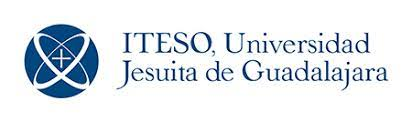
<h1><center>ITESO PhD in Engineering Sciences</h1></center>

<center>DOCTORAL PROGRAM IN ENGINEERING SCIENCES AT ITESO</center>
<center>RECTIFICATION OF THERMAL IMAGE REPRESENTATION USING NEURAL NETWORKS BY USING CHEAP THERMAL FLIR© CAMERA.</center>
<center>Marco Ramirez-Martagon, Ivan Villalon-Turrubiates, and Oscar Rojas-Rejon</center>
        
<center>July 1, 2021</center>
<center>Tlaquepaque, México 45604</center>
<center>Doctoral Program in Engineering Sciences</center>
<center>ITESO (Instituto Tecnológico y de Estudios Superiores de Occidente)</center>

<h3>Introduction</h3>

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
#import collections
import subprocess
import time
import json
import csv
import os
import io
%matplotlib inline
# Avoid pritn Warnings 
import warnings
warnings.filterwarnings('ignore')


import tensorflow as tf
tf.__version__

'2.5.0'

In [ ]:
!apt install exiftool

In [2]:
def extractDigitstoFloat(Str):
    tmp=''.join(c for c in Str if (c.isdigit() or c=='.') )
    if ( len ( tmp.split('.') ) > 1 ) :
      digit = tmp.split('.')[0]+'.'+tmp.split('.')[1]
    else :
      digit = tmp
    return float(digit)

In [3]:
#Each temperature value ( Raw Data ) is store in 32 bits ( 1 word )
def getThermal(JPGFile,debug=False,H5=None):

   RAW_IMG          = None
   RAW_DATA         = None
   VISUAL_IMG       = None
   v0x0000          = np.vectorize(hex)
   ByteOrder        = None
   SpotRGB_image    = None
   SpotBW_image     = None
   Y_hat            = None
   RadiometricImage = None
    
   TagDic={     'ObjectDistance':0.0,
                'Emissivity':0.0,
                'ReflectedApparentTemperature':0.0,
                'IRWindowTemperature':0.0,
                'IRWindowTransmission':0.0,
                'PlanckB':0.0,
                'PlanckO':0.0,
                'PlanckR1':0.0, 
                'PlanckR2':0.0 ,
                'AtmosphericTransAlpha1':0.0,
                'AtmosphericTransAlpha2':0.0,
                'AtmosphericTransBeta1':0.0,
                'AtmosphericTransBeta2':0.0,
                'AtmosphericTransX':0.0
          }

   SpotDic={    'RawX'    : None, 
                'RawY'    : None,
                'Raw'     : None,
                'K'       : None,
                'C'       : None} # Temp in Kelvin and Celcius

   ImgSizeDic={ 'ExifImageWidth'        : None,
                "RawThermalImageWidth"  : None,
                "ExifImageHeight"       : None,
                "RawThermalImageHeight" : None }

   RawStatDic={'Max'   : None,
               'Min'   : None,
               'Slope' : None}
   
   try :
        RadiometricImage=Image.open(JPGFile)
        process_catch = subprocess.check_output(['exiftool',  '-j', JPGFile])
        D             = json.loads(process_catch.decode())[0]

        if  ("EmbeddedImage" in D) or ("ThumbnailImage" in D) :
            if   ("EmbeddedImage" in D): 
                  process_catch = subprocess.check_output(['exiftool', "-EmbeddedImage", "-b", JPGFile])
            elif ("ThumbnailImage" in D):
                  process_catch = subprocess.check_output(['exiftool', "-ThumbnailImage", "-b", JPGFile])
            else :
                  print("ERROR : RGB Image not found")                
            process_bytes = io.BytesIO(process_catch)
            VISUAL_IMG       = Image.open(process_bytes)
            if debug:
                print("INFO : Visual Image processed")
                                                    
        if "RawThermalImage" in D:
            TagDic['ObjectDistance']  = extractDigitstoFloat(D['ObjectDistance'])
            TagDic['Emissivity']      = D['Emissivity'] 
            TagDic['RelativeHumidity']= extractDigitstoFloat(D['RelativeHumidity']) # Constant
            TagDic['ReflectedApparentTemperature']= extractDigitstoFloat(D['ReflectedApparentTemperature'])
            TagDic['AtmosphericTemperature']      = extractDigitstoFloat(D['AtmosphericTemperature'])
            TagDic['IRWindowTemperature']         = extractDigitstoFloat(D['IRWindowTemperature'])
            TagDic['IRWindowTransmission']        = D['IRWindowTransmission']
            TagDic['PlanckB']      = D['PlanckB']
            TagDic['PlanckF']      = D['PlanckF'] # Constant
            TagDic['PlanckO']      = D['PlanckO']
            TagDic['PlanckR1']     = D['PlanckR1'] 
            TagDic['PlanckR2']     = D['PlanckR2']
            TagDic['AtmosphericTransAlpha1']=D['AtmosphericTransAlpha1'] # Constant
            TagDic['AtmosphericTransAlpha2']=D['AtmosphericTransAlpha2'] # Constant
            TagDic['AtmosphericTransBeta1'] =D['AtmosphericTransBeta1']  # Constant
            TagDic['AtmosphericTransBeta2'] =D['AtmosphericTransBeta2']  # Constant
            TagDic['AtmosphericTransX']     =D['AtmosphericTransX']      # Constant
            
            process_catch = subprocess.check_output(['exiftool', "-RawThermalImage", "-b", JPGFile])
            process_bytes = io.BytesIO(process_catch)
            RAW_IMG       = Image.open(process_bytes)
            RAW_DATA      = np.asarray(RAW_IMG)
            
            if debug :
                print("===== Raw Data Shape:{} Type:{} ==========".format(RAW_DATA.shape,RAW_DATA.dtype))
                print(v0x0000(RAW_DATA[50:55] ))
            
            ByteOrder   = D['ExifByteOrder']
    
            if ByteOrder.upper().find('LITTLE-ENDIAN') >= 0 :
                if debug:
                    print("INFO : Apply {} translation ".format(ByteOrder))
                RAW_DATA = np.vectorize(lambda x: (x >> 8) + ((x & 0x00ff) << 8))(RAW_DATA)                    
                
                if debug:
                    print("===== Raw Data Shape:{} Type:{} Transformed by {} ==========".format(RAW_DATA.shape,RAW_DATA.dtype,ByteOrder))
                    print(v0x0000(RAW_DATA[50:55] ))
                RAW_IMG=Image.fromarray(  (RAW_DATA * 255).astype(np.uint8)   )
            else:
                RAW_IMG=Image.fromarray(RAW_DATA)
            
            RawStatDic['Max']=np.max(RAW_DATA)
            RawStatDic['Min']=np.min(RAW_DATA)
            RawStatDic['Slope']=np.max(RAW_DATA)-np.min(RAW_DATA)
            
            if H5 is not None :
               try:
                        _, h5name = os.path.split(H5)
                        if debug:
                            print("INFO : Loading model {}".format(h5name))
                        model = tf.keras.models.load_model(H5)
                        NumberFeatures = model.layers[0].input.shape[1]
                        C1=RAW_DATA.flatten().T
                        Y=np.zeros( (C1.shape[0], NumberFeatures-1) )
                        #10 Features
                        #'Raw','Distance','Emissivity','ReflectedApparentTemperature','IRWindowTemperature',
                        #           'IRWindowTransmission','PlanckB','PlanckO','PlanckR1','PlanckR2' ] ] )
                        # 
                        if NumberFeatures == 10 :
                            Y[:, [0]] = TagDic['ObjectDistance']
                            Y[:, [1]] = TagDic['Emissivity']
                            Y[:, [2]] = TagDic['ReflectedApparentTemperature']
                            Y[:, [3]] = TagDic['IRWindowTemperature']
                            Y[:, [4]] = TagDic['IRWindowTransmission']
                            Y[:, [5]] = TagDic['PlanckB']
                            Y[:, [6]] = TagDic['PlanckO']
                            Y[:, [7]] = TagDic['PlanckR1']
                            Y[:, [8]] = TagDic['PlanckR2']
                            Y=np.insert(Y, 0, C1, axis=1)
                        elif NumberFeatures == 18:
                            Y[:, [0]] = TagDic['ObjectDistance']
                            Y[:, [1]] = TagDic['Emissivity']
                            Y[:, [2]] = TagDic['ReflectedApparentTemperature']
                            Y[:, [3]] = TagDic['AtmosphericTemperature']
                            Y[:, [4]] = TagDic['IRWindowTemperature']
                            Y[:, [5]] = TagDic['IRWindowTransmission']
                            Y[:, [6]] = TagDic['RelativeHumidity']
                            Y[:, [7]] = TagDic['PlanckB']
                            Y[:, [8]] = TagDic['PlanckF']
                            Y[:, [9]] = TagDic['PlanckO']
                            Y[:, [10]] = TagDic['PlanckR1']
                            Y[:, [11]] = TagDic['PlanckR2']
                            Y[:, [12]] = TagDic['AtmosphericTransAlpha1']
                            Y[:, [13]] = TagDic['AtmosphericTransAlpha2']
                            Y[:, [14]] = TagDic['AtmosphericTransBeta1'] 
                            Y[:, [15]] = TagDic['AtmosphericTransBeta2'] 
                            Y[:, [16]] = TagDic['AtmosphericTransX']
                            Y=np.insert(Y, 0, C1, axis=1)
                        else:
                            Y=None
                        if debug:
                            print("INFO : Start prediction")
                        Y_hat = model.predict(Y).flatten()
                        if debug:
                            print("INFO : End prediction")
                        Y_hat=Y_hat.reshape(RAW_DATA.shape[0],RAW_DATA.shape[1])
                        if debug:
                            print("INFO : Temperature Matrix shape {}".format(Y_hat.shape))
                                    
                        
               except  Exception as e:
                        print("ERROR : On H5 model {}, {} ".format ( H5, str(e)) )
            
            if debug:
                print("INFO : Thermal Image processed")

            if ("Meas1Type" in D ) and ( "Meas1Params" in D):
                   multi_x= D["ExifImageWidth"]/D["RawThermalImageWidth"]
                   multi_y= D["ExifImageHeight"]/D["RawThermalImageHeight"]
                   ImgSizeDic['ExifImageWidth']=D["ExifImageWidth"]
                   ImgSizeDic["RawThermalImageWidth"]=D["RawThermalImageWidth"]
                   ImgSizeDic["ExifImageHeight"]=D["ExifImageHeight"]
                   ImgSizeDic["RawThermalImageHeight"]=D["RawThermalImageHeight"]
                   if ( D["Meas1Type"].strip().upper() == "SPOT"): # D["Meas1Params"]    ROW  COL
                       if debug :
                            print("INFO : Processing Spot")
                        
                       SpotDic['RawX']=int(D["Meas1Params"].split(' ')[0].strip())    # ROW
                       SpotDic['RawY']=int(D["Meas1Params"].split(' ')[1].strip())    # COL
                     
                       SpotX=int( int(D["Meas1Params"].split(' ')[0].strip())*multi_x ) # On Thermal Represent
                       SpotY=int( int(D["Meas1Params"].split(' ')[1].strip())*multi_y )
                    
                       SpotDic['Raw']   =       RAW_DATA[ SpotDic['RawX'],  SpotDic['RawY'] ]
                       #print("Row {} val {}".format(SpotDic['RawY'], thermal_np[ SpotDic['RawY'] ]))
                       #SpotDic['RawHex']=  hex( thermal_np[ SpotDic['RawY'] ] [ SpotDic['RawX'] ] )
                       thresh = 172
                       fn = lambda x : 255 if x > thresh else 0
                       SpotRGB_image=RadiometricImage.crop((SpotX+4*multi_x , 
                                                              SpotY+4*multi_x , 
                                                              SpotX+100*multi_y, 
                                                              SpotY+32*multi_y))
                       SpotBW_image = SpotRGB_image.convert('L').point(fn, mode='1').resize((120, 30), Image.ANTIALIAS)
                       #filter(ImageFilter.GaussianBlur(radius = 0.5)).
                       #cropped_image=cropped_image.filter(ImageFilter.BLUR)
                       #cropped_image=cropped_image.convert('L').point(fn, mode='1')
                       if Y_hat is not None:
                           SpotDic['K']=Y_hat[SpotDic['RawX'],SpotDic['RawY']] 
                           SpotDic['C']=Y_hat[SpotDic['RawX'],SpotDic['RawY']] - 273.15 
                           if debug:
                                print("INFO : Spot Temp. prediction {}K {}C".format( SpotDic['K'], SpotDic['C']))
        else:
            print("ERROR : No Embedded Thermal Raw Data  found")                                           
   except  Exception as e:
            print("ERROR : Processing {} File Exception {}".format ( JPGFile, str(e)) )
        
   return VISUAL_IMG,RAW_IMG, RadiometricImage ,Y_hat,ByteOrder,TagDic, SpotDic,ImgSizeDic,RawStatDic,SpotRGB_image,SpotBW_image

{'ObjectDistance': 3.0, 'Emissivity': 0.8, 'ReflectedApparentTemperature': 22.0, 'IRWindowTemperature': 25.0, 'IRWindowTransmission': 0.8, 'PlanckB': 1530, 'PlanckO': -1672, 'PlanckR1': 5980.5498, 'PlanckR2': 0.0125, 'AtmosphericTransAlpha1': 0.006569, 'AtmosphericTransAlpha2': 0.01262, 'AtmosphericTransBeta1': -0.002276, 'AtmosphericTransBeta2': -0.006677, 'AtmosphericTransX': 1.9, 'RelativeHumidity': 50.0, 'AtmosphericTemperature': 20.0, 'PlanckF': 1}
{'RawX': 251, 'RawY': 38, 'Raw': 4540, 'K': 298.75745, 'C': 25.607446289062523}
{'Max': 4764, 'Min': 4356, 'Slope': 408}


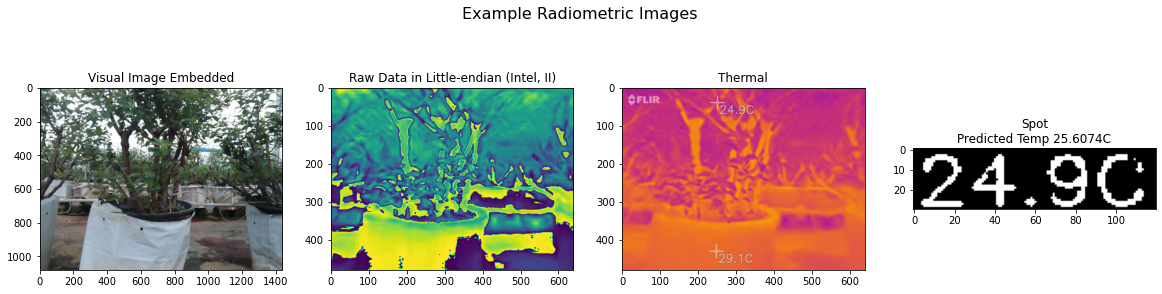

In [4]:
H5model='/Users/marco/Documents/000-ITESO/IDI10/workspace/try02/16x16x16x1-50000e.h5'
RGB,BW,Thermal,Y,ByteOrder,TagDic,SpotDic,ImgSizeDic,RawStatDic,SpotRGB,SpotBW=getThermal('/Users/marco/Documents/000-ITESO/IDI10/workspace/img/others/Hierro.JPG',debug=False,H5=H5model)


f, axarr = plt.subplots(1,4,figsize=(20, 5)) 
f.suptitle("Example Radiometric Images", fontsize=16)
axarr[0].imshow(RGB)
axarr[0].set_title("Visual Image Embedded")
axarr[1].imshow(BW)
axarr[1].set_title("Raw Data {}".format ( "in "+ByteOrder if len(ByteOrder)>0 else ""))
axarr[2].imshow(Thermal)
axarr[2].set_title("Thermal")
if SpotBW is not None :
    axarr[3].imshow(SpotBW)
    if SpotDic['C'] is not None:
        axarr[3].set_title("Spot\nPredicted Temp {:.4f}C".format(SpotDic['C'])) 
    else:
        axarr[3].set_title("Spot\n{}".format(SpotDic))
        


print(TagDic)
print(SpotDic)
print(RawStatDic)





In [ ]:

RGB,BW,Thermal,Y,ByteOrder,TagDic,SpotDic,ImgSizeDic,RawStatDic,SpotRGB,SpotBW=getThermal('/Users/marco/Documents/000-ITESO/IDI10/workspace/img/others/flir_20210711T122652.jpg')


f, axarr = plt.subplots(1,4,figsize=(20, 5)) 
f.suptitle("Example Radiometric Images", fontsize=16)
axarr[0].imshow(RGB)
axarr[0].set_title("Visual Image Embedded")
axarr[1].imshow(BW)
axarr[1].set_title("Raw Data {}".format ( "in "+ByteOrder if len(ByteOrder)>0 else ""))
axarr[2].imshow(Thermal)
axarr[2].set_title("Thermal")
if SpotBW is not None :
    axarr[3].imshow(SpotBW)
    if SpotDic['C'] is not None:
        axarr[3].set_title("Spot\nPredicted Temp {:.4f}C".format(SpotDic['C'])) 
    else:
        axarr[3].set_title("Spot\n{}".format(SpotDic))
        


print(TagDic)
print(SpotDic)
print(RawStatDic)

